# Part 6: Basic Panoramic Image

In [14]:
import numpy as np
import scipy.linalg as linalg
import cv2
from PIL import Image
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

1. Preparation stage: Get the features 

In [15]:
# Read all the images:
img1 = cv2.imread('im01.jpg')
img2 = cv2.imread('im02.jpg')
img3 = cv2.imread('im03.jpg') 
img4 = cv2.imread('im04.jpg')
img5 = cv2.imread('im04.jpg') 
# # get the SIFT features of all images:
siftCreater = cv2.SIFT_create()
# kps1, des1 = siftCreater.detectAndCompute(img1, None)
# kps2, des2 = siftCreater.detectAndCompute(img2, None)
# kps3, des3 = siftCreater.detectAndCompute(img3, None)
# kps4, des4 = siftCreater.detectAndCompute(img4, None)
# kps5, des5 = siftCreater.detectAndCompute(img5, None)

2. Function to Find the Matches

In [16]:
def findMatches(kps1, kps2, des1, des2):
    # for each kp in kp1 of img1, find the match in kps2 of img2:
    kpNum1 = des1.shape[0]
    kpNum2 = des2.shape[0]
    # print(kpNum1, kpNum2)

    matches = np.zeros((kpNum1,5))
    for i in range(0,kpNum1):
        minDist = np.linalg.norm(des1[i] - des2[0])
        matches[i][0] = kps1[i].pt[0]
        matches[i][1] = kps1[i].pt[1]
        matches[i][2] = kps2[0].pt[0]
        matches[i][3] = kps2[0].pt[1]
        matches[i][4] = minDist
        for j in range(1, kpNum2):
            newDist = np.linalg.norm(des1[i] - des2[j])
            if newDist < minDist:
                minDist = newDist
                matches[i][0] = kps1[i].pt[0]
                matches[i][1] = kps1[i].pt[1]
                matches[i][2] = kps2[j].pt[0]
                matches[i][3] = kps2[j].pt[1]
                matches[i][4] = minDist
    return matches

In [17]:
# findMatches(kps1, kps2, des1, des2)

In [18]:
def reduceMatches(matches):
    # reduce the number of matches:
    newMatchesSize = int(matches.shape[0]/14)
    matches = matches[np.argsort(matches[:, 4])]
    newMat = matches[0:newMatchesSize,0:5]
    return newMat

In [19]:
# reduceMatches(findMatches(kps1, kps2, des1, des2))

3. Functions to do RANSAC:

In [20]:
import random
def selectRandomMatches(newMat):
    matchesSize = newMat.shape[0]
    randomMatPoses = random.sample(range(0, matchesSize),4)
#     print(randomMatPoses)
    randomMat = []
    for i in randomMatPoses:
        kp1 = np.array([newMat[i][0], newMat[i][1], 1])
        kp2 = np.array([newMat[i][2], newMat[i][3], 1])
#         kp1 = np.array([newMat[i][1], newMat[i][0], 1])
#         kp2 = np.array([newMat[i][3], newMat[i][2], 1])    
        randomMat.append([kp1, kp2])
    return randomMat

def getHomographyOfRandomSize(points):
    # computes homography matrix of any sizes:
    length = len(points)
    A = np.zeros((length*2, 9))
    
    i=0
    while i < (length):
        j = i*2
        A[j][0:3] = np.array([points[i][0]])
        A[j][6:9] = np.array([-points[i][0][0]*points[i][1][0], -points[i][0][1]*points[i][1][0], -points[i][1][0]])
        A[j+1][3:6] = np.array([points[i][0]])
        A[j+1][6:9] = np.array([-points[i][0][0]*points[i][1][1], -points[i][0][1]*points[i][1][1], -points[i][1][1]])
        i+=1
#     print(A)
    U, D, Vt = linalg.svd(A)
    H = Vt[-1].reshape(3,3)
#     print(H)
    
    return H

def getRandomHomography(mat):
    # select 5 random matching points and computes the random homography
    # 1. select 5 random rows from the matching arry:
    randomMat = selectRandomMatches(mat)
    # 2. computes homography based on the 5 points and return:
    return getHomographyOfRandomSize(randomMat)

# Set epsilon to be 50
def getInliners(H, newMat):
    # 1. count the inliners w.r.t. epsilon = 50:
    epsilon = 50
    # 2. initialize the list of inliners and error
    inliners = []
    totalErr = 0
    # 3. loop to search if there is a inliner in the matching pairs
    newMatSize = newMat.shape[0]
    for i in range(0, newMatSize):
        # 3.1.i get the kp1 in img1 and transforms:
        coord1 = np.array([newMat[i][0], newMat[i][1], 1])
        transCoord1 = H.dot(coord1) # transforms by H
        transCoord1 = transCoord1/transCoord1[2] # normalization
        # 3.2. get the matching kp2 in img2 of that in img1
        coord2 = np.array([newMat[i][2], newMat[i][3], 1])
        # 3.3. work out the distance between kp2 and H*kp1
        dist = np.linalg.norm(transCoord1 - coord2)
        # 3.4 updates the inliner list if the current pair is close enough: dist < epsilon
        if dist < epsilon:
            inliners.append([coord1, coord2])
            totalErr+=dist # work out the total error of the current list of inliners
    # 4. returns the inliners and the corresponding error:
    return inliners, totalErr

def ransac(img1, img2):
    # define the number of iterations:
    T = 10000
    # define the maximum set of inliners and best(smallest error)
    maxInliners = []
    maxInlinersNum = 0
    bestErr = 0
    # get the newMat:
    kps1, des1 = siftCreater.detectAndCompute(img1, None)
    kps2, des2 = siftCreater.detectAndCompute(img2, None)
    newMat = reduceMatches(findMatches(kps1, kps2, des1, des2))
    # loop for T interations to find the best homography that most points agrees
    superH = np.zeros((3,3))
    for i in range(0, T):
#         print(i)
        # select a random homography:
        H = getRandomHomography(newMat)
        # count the inliners:
        inliners, err = getInliners(H, newMat)
        # update the best set of inliners and errors
        if (i == 0):
            superH = H
            bestErr = err
            maxInliners = inliners
        if (maxInlinersNum < len(inliners)) or (bestErr > err):
            superH = H
            maxInliners = inliners
            maxInlinersNum = len(inliners)
    # recompute the homography on all the inliners from the maximum inliners-set
    maxInlinersArr = np.zeros((maxInlinersNum, 4))
    for i in range(0, maxInlinersNum):
        maxInlinersArr[i,0:2] = np.array([maxInliners[i][0][0], maxInliners[i][0][1]])
        maxInlinersArr[i,2:4] = np.array([maxInliners[i][1][0], maxInliners[i][1][1]])
    
#     superH = getRandomHomography(maxInlinersArr)
#     print(maxInliners)
    return maxInliners, superH

def doRansacAndShow(img1, img2):
    # prepare a new canvas
    imgSizeY1 = img1.shape[0]
    imgSizeX1 = img1.shape[1]
    imgSizeY2 = img2.shape[0]
    imgSizeX2 = img2.shape[1]
    newImg = np.zeros((max(imgSizeY1, imgSizeY2), (imgSizeX1 + imgSizeX2), 3), dtype="uint8")
    
    # paste the two images on the new canvas
    newImg[0:imgSizeY1, 0:imgSizeX1] = img1
    newImg[0:imgSizeY2, imgSizeX1:] = img2

    # get the maximum set of inliners and best homography(superH) on all the inliners from ransac()
    maxInliners, superH = ransac(img1, img2)
    print("superH:")
    print(superH)
    length = len(maxInliners)

    # draw the matching graph:
    i=0
    while(i < (length)):
        pt1 = (int(maxInliners[i][0][0]), int(maxInliners[i][0][1]))
        pt2 = ((int(maxInliners[i][1][0]) + imgSizeX1), int(maxInliners[i][1][1]))
        cv2.line(newImg, pt1, pt2, (0, 255, 0), 1)
        i+=1
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.imshow(cv2.cvtColor(newImg,cv2.COLOR_BGR2RGB), interpolation='none')
    plt.show()
    return superH

superH:
[[-3.27082605e-03  1.44073246e-04  9.62650095e-01]
 [-8.63232200e-04 -2.56930071e-03  2.70710511e-01]
 [-2.83928695e-06  5.37638180e-07 -1.59613374e-03]]


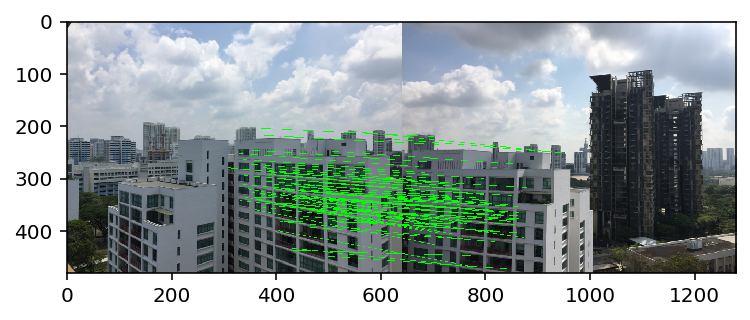

In [28]:
superH = doRansacAndShow(img1, img2)

In [22]:
def getMinMax(array, maxXLimit, maxYLimit, minXLimit, minYLimit):
    size = array.shape[1]
    # find minX and maxX:
    xSortedArr = array[:, array[0, :].argsort()]
    i = 0
    minX = xSortedArr[0, i]
    while(i < size-1 and xSortedArr[0, i] <= minXLimit):
        i+=1
        minX = xSortedArr[0, i]
    
    j = size-1
    maxX= xSortedArr[0, j]
    while(j > 1 and xSortedArr[0, j] >= maxXLimit):
        j-=1
        maxX = xSortedArr[0, j]
    
    # find minY and maxY:
    ySortedArr = array[:, array[1, :].argsort()]

    i = 0    
    minY = ySortedArr[1, i]
    while(i < size-1 and ySortedArr[1, i] <= minYLimit):
        i+=1
        minY = ySortedArr[1, i]
    
    j = size-1
    maxY= ySortedArr[1, j]
    while(j > 1 and ySortedArr[1, j] >= maxYLimit):
        j-=1
        maxY = ySortedArr[1, j]
        
    return minX, minY, maxX, maxY

def computeHomographyAndConcat1(img1, img2, H):
    imgSizeX1 = img1.shape[0]
    imgSizeY1 = img1.shape[1]
    imgSizeX2 = img2.shape[0]
    imgSizeY2 = img2.shape[1]
    
    maxXLimit = imgSizeX1
    maxYLimit = imgSizeY1
    minXLimit = -maxXLimit
    minYLimit = -maxYLimit

    i, cnt= 0, 0
    step = 0.5
    newPos = np.zeros((3,int(imgSizeX1/step)*int(imgSizeY1/step)))
    while(i < imgSizeY1):
        j=0
        while(j < imgSizeX1):
            newPos[:,cnt] = H.dot(np.array([i,j,1]))
            newPos[:,cnt] = newPos[:,cnt]/newPos[2,cnt]
            newPos[0,cnt] = newPos[0,cnt]
            newPos[1,cnt] = newPos[1,cnt]
            j+=step
            cnt+=1
        i+=step
    # get the minimum and maximum poses of the orgPoses
    minX, minY, maxX, maxY = getMinMax(newPos, maxXLimit, maxYLimit, minXLimit, minYLimit)
    # shifting img1, shifting the maximum size of the canvas
    shiftX = 0
    shiftY = 0
    if minX < 0:
        newPos[0,:] += abs(minX)
        shiftX = int(abs(minX))
        maxX += abs(minX)
    if minY < 0:
        newPos[1,:] += abs(minY)
        shiftY = int(abs(minY))
        maxY += abs(minY)
    # get the new canvas
    newSizeX = int(maxX)+imgSizeX2
    newSizeY = int(maxY)+imgSizeY2
    newImg = np.zeros((newSizeX, newSizeY, 3),np.uint8)
    # prepare img2 on the new canvas
    for i in range(0,int(imgSizeX2)):
        for j in range(0,int(imgSizeY2)):
            newImg[i+shiftY][j+shiftX] = img2[i][j]
    # loop to prepare img1 on the new canvas             
    i, cnt= 0, 0
    step = 0.5
    while(i < imgSizeY1):
        j=0
        while(j < imgSizeX1):
            newPosX = int(newPos[0][cnt]) # round the indexes to integer
            newPosY = int(newPos[1][cnt])
            if((newPosX >= 0 and newPosX < newSizeY) and (newPosY >= 0 and newPosY < newSizeX)):
                newImg[newPosY][newPosX] = img1[int(j)][int(i)]
            j+=step
            cnt+=1
        i+=step
    
    return newImg

In [23]:
def drawImage(newImg):
    # Draw img
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    plt.imshow(newImg/255)
    plt.show()

4. Stitch im01 and im02

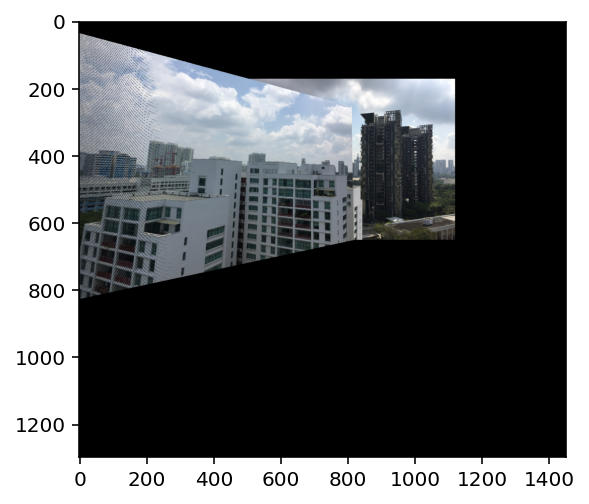

In [29]:
tempImg1 = computeHomographyAndConcat1(img1, img2, superH)
# print(tempImg1)
tempImg1 = cv2.cvtColor(tempImg1, cv2.COLOR_BGR2RGB)
drawImage(tempImg1)

5.  Stitch im03:

superH:
[[ 8.26298402e-04 -8.05080295e-05  9.49138248e-01]
 [-2.26992147e-04  1.26162579e-03  3.14852560e-01]
 [-5.65114582e-07 -7.13665587e-08  1.45548890e-03]]


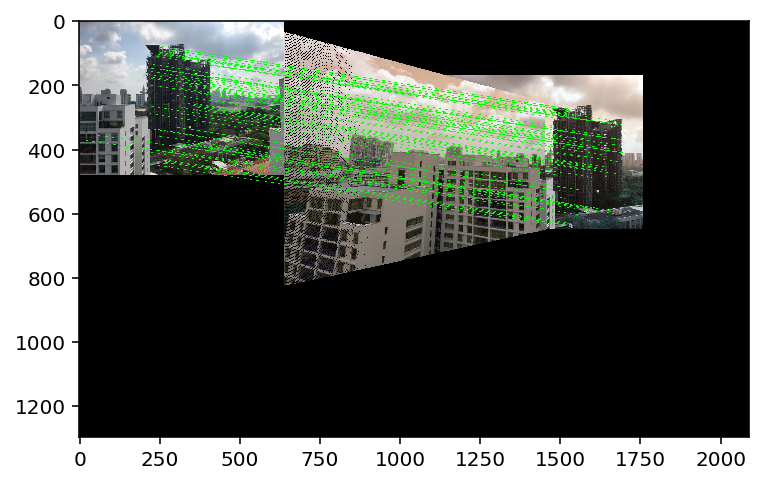

In [30]:
superH1 = doRansacAndShow(img3, tempImg1)

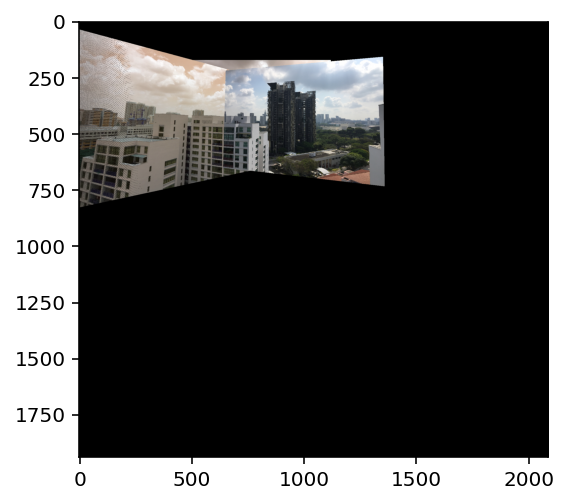

In [31]:
tempImg2 = computeHomographyAndConcat1(img3, tempImg1, superH1)
# print(tempImg1)
tempImg2 = cv2.cvtColor(tempImg2, cv2.COLOR_BGR2RGB)
drawImage(tempImg2)

6.  Stitch im04:

superH:
[[ 4.54437398e-04  4.44133792e-05  9.65500143e-01]
 [-3.11615755e-04  1.18787362e-03  2.60395883e-01]
 [-8.16304183e-07  6.06327502e-08  1.31926069e-03]]


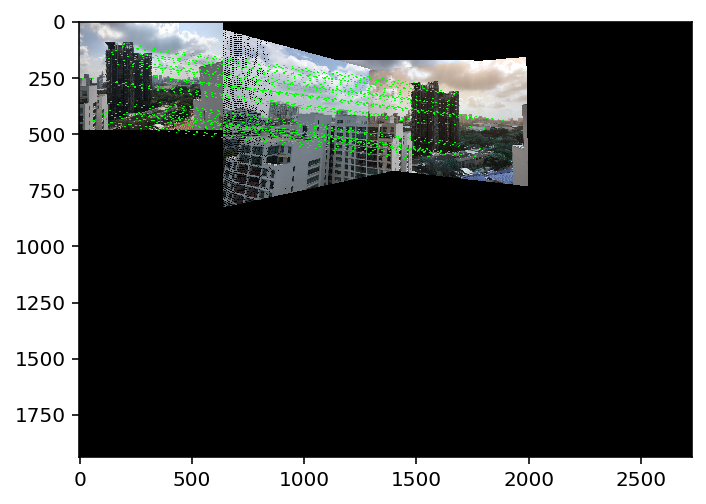

In [32]:
superH2 = doRansacAndShow(img4, tempImg2)

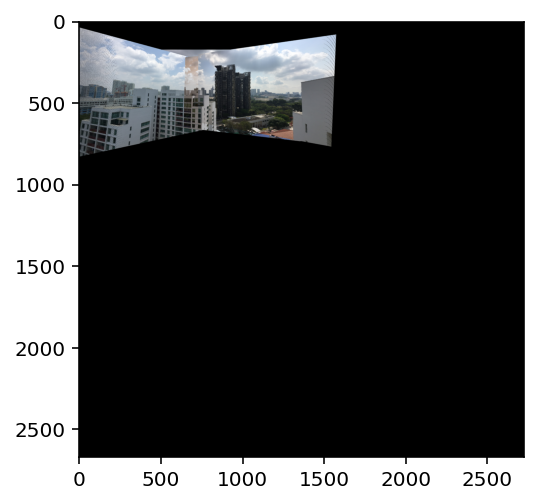

In [33]:
tempImg3 = computeHomographyAndConcat1(img4, tempImg2, superH2)
# print(tempImg1)
tempImg3 = cv2.cvtColor(tempImg3, cv2.COLOR_BGR2RGB)
drawImage(tempImg3)

7.  Stitch im05:

superH:
[[ 4.46525138e-04  6.24965131e-05  9.65813753e-01]
 [-3.20358042e-04  1.20441983e-03  2.59230192e-01]
 [-8.30308804e-07  8.09534115e-08  1.32121005e-03]]


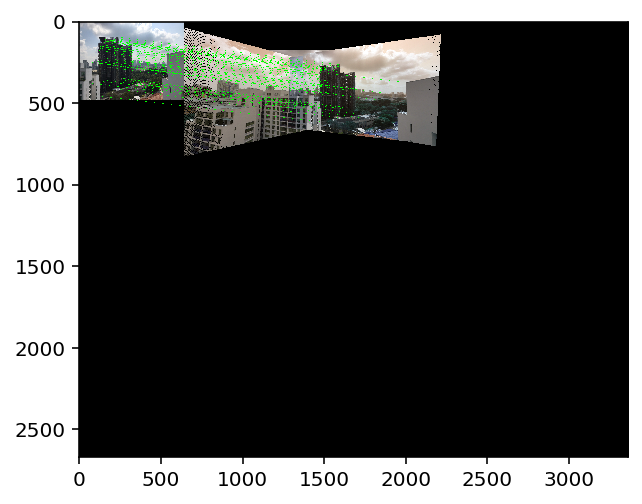

In [34]:
superH3 = doRansacAndShow(img5, tempImg3)

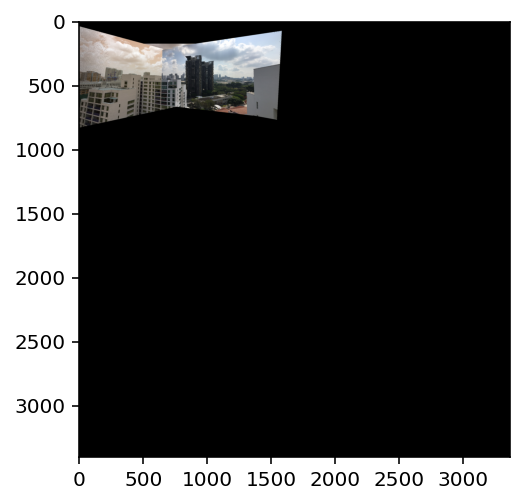

In [37]:
tempImg4 = computeHomographyAndConcat1(img5, tempImg3, superH3)
# print(tempImg1)
tempImg4 = cv2.cvtColor(tempImg4, cv2.COLOR_BGR2RGB)
drawImage(tempImg4)

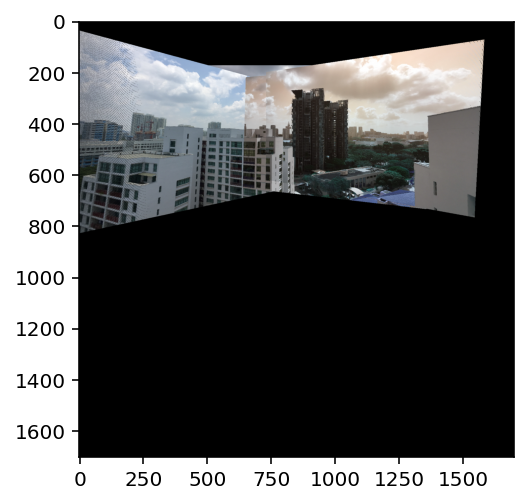

In [36]:
tempImg5 = tempImg4[0:1700, 0:1700]
tempImg5 = cv2.cvtColor(tempImg5, cv2.COLOR_BGR2RGB)
drawImage(tempImg5)